** HALLO

Vette shit hier

In [1]:
%matplotlib inline

import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
from IPython import display

def print_fl(output):
    print(output)
    sys.stdout.flush()

Hallo

In [2]:
T = 200.0
h = 0.004
numSteps = int(T/h)
numFrames = 20
reportFreq = 0.01
t = 0

M = 4
n = 4*M**3
v = np.zeros((numSteps,n,3))
r = np.zeros((numSteps,n,3))
v_hat = np.zeros((numSteps,n,3))
m = 1.0
temp = 1.0
beta = 1/temp
sigma_v = np.sqrt(1/(beta * m))
rho = 1.0
L = np.power(n/rho, 1/3)

dist = np.zeros((numSteps,n,n))
F = np.zeros((numSteps,n,3))



In [3]:
def initialise(set_v = True):
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    t = 0
    i = 0
    for mx in range(0, M):
        for my in range(0, M):
            for mz in range(0, M):
                r[t,i,0] = L*mx/M; r[t,i,1] = L*my/M; r[t,i,2] = L*mz/M
                i += 1
                r[t,i,0] = L*(mx+0.5)/M; r[t,i,1] = L*(my+0.5)/M; r[t,i,2] = L*mz/M
                i += 1
                r[t,i,0] = L*(mx+0.5)/M; r[t,i,1] = L*my/M; r[t,i,2] = L*(mz+0.5)/M
                i += 1
                r[t,i,0] = L*mx/M; r[t,i,1] = L*(my+0.5)/M; r[t,i,2] = L*(mz+0.5)/M
                i += 1
    if set_v:
        v[t,:,:] = np.random.normal(0.0, sigma_v, size=(n,3))
        v[t,:,:] = (v[t,:,:] - np.mean(v[t,:,:], axis=0)) / np.std(v[t,:,:]) * sigma_v
    else:
        v[t,:,:] = 0.0


def initialise_simple():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    
    M = 3
    n = 2
    
    v = np.zeros((numSteps,n,3))
    r = np.zeros((numSteps,n,3))
    v_hat = np.zeros((numSteps,n,3))
    
    L = 3

    dist = np.zeros((numSteps,n,n))
    F = np.zeros((numSteps,n,3))
    
    v[t,:,:] = 0.0
    r[t,0,:] = [L-0.55*np.power(2.0,1.0/6.0), L/2, L/2]
    r[t,1,:] = [0.55*np.power(2.0,1.0/6.0), L/2, L/2]

def update_coordinates():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    v_hat[t,:,:] = v[t,:,:] + h * F[t,:,:]/2
    r[t + 1,:,:] = (r[t,:,:] + h * v_hat[t,:,:]) % L
    
    t += 1
    calculate_forces()
    v[t,:,:] = v_hat[t-1,:,:] + h*F[t,:,:] / 2

In [4]:
@jit(nopython=True)
def calculate_distances_jit(rIn, nIn, LIn):
    #nIn = rIn.shape[0]
    distOut = np.zeros((nIn, nIn))
    epsilon = 1e-12
    for i in range(0,nIn):
        for j in range(0,i):
            dx = rIn[i,0] - rIn[j,0]
            dx -= np.around(dx/LIn) * LIn
            
            dy = rIn[i,1] - rIn[j,1]
            dy -= np.around(dy/LIn) * LIn
            
            dz = rIn[i,2] - rIn[j,2]
            dz -= np.around(dz/LIn) * LIn
            
            dr = np.sqrt(dx*dx + dy*dy + dz*dz)
            if not dr == 0.0:
                distOut[i,j] = distOut[j,i] = dr
            else:
                distOut[i,j] = distOut[j,i] = epsilon
    return distOut

def calculate_distances():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    dist[t,:,:] = calculate_distances_jit(r[t,:,:], n, L)
    
@jit(nopython=True)
def calculate_forces_jit(rIn, dIn, nIn, LIn):
    #nIn = rIn.shape[0]
    Fij = np.zeros((nIn, nIn, 3))
    for i in range(0,nIn):
        for j in range(0,i):
            dx = rIn[i,0] - rIn[j,0]
            dx -= np.around(dx/LIn) * LIn
            
            dy = rIn[i,1] - rIn[j,1]
            dy -= np.around(dy/LIn) * LIn
            
            dz = rIn[i,2] - rIn[j,2]
            dz -= np.around(dz/LIn) * LIn
            
            fLJ = (48.0/(dIn[i,j]**14) - 24.0/(dIn[i,j]**8))
            Fij[i,j,0] = dx * fLJ
            Fij[i,j,1] = dy * fLJ
            Fij[i,j,2] = dz * fLJ
            
            Fij[j,i,0] = -Fij[i,j,0]
            Fij[j,i,1] = -Fij[i,j,1]
            Fij[j,i,2] = -Fij[i,j,2]
    return Fij

def calculate_forces():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    calculate_distances()
    F[t,:,:] = np.sum(calculate_forces_jit(r[t,:,:], dist[t,:,:], n, L), axis=1)

In [5]:
def do_simulation():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho  
    global numFrames
    start_visualisation()
    
    initialise()
    calculate_forces()
    while(t < numSteps - 1):
        if (t % int(numSteps*reportFreq) == 0):
            print_fl("Simulation progress: " + str(int(t*100/numSteps)) + "%")
        if (t % int(numSteps/numFrames) == 0):
            visualize()   
        update_coordinates()
    end_visualisation()
    print_fl("Simulation finished")

fig = None
ax = None

def start_visualisation():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global fig, ax
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
def end_visualisation():
    display.clear_output()

def visualize():
    global T, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global fig, ax
    ax.cla()
    ax.scatter(r[t,:,0], r[t,:,1], r[t,:,2])
    ax.set_xlim((0.0, L))
    ax.set_ylim((0.0, L))
    ax.set_zlim((0.0, L))
    display.clear_output(wait=True)
    display.display(fig)
    #time.sleep(0.05)

In [6]:
initialise()

In [7]:
def test_update_coordinates():
    global t
    update_coordinates()
    t -= 1
    
calculate_forces()
test_update_coordinates()

%timeit test_update_coordinates()

100 loops, best of 3: 2.19 ms per loop


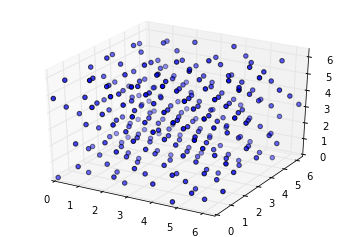

In [8]:
do_simulation()

In [13]:
def determine_kinetic_energy():
    global v
    v_sq = np.sum(v[:-1]*v[:-1], axis=(1,2)) 
    return v_sq

@jit(nopython=True)
def calculate_LJ_potential_jit(dIn):
    numStepsIn = dIn.shape[0] - 1
    nIn = dIn.shape[1]
    U = np.zeros(numStepsIn)
    for k in range(0, numStepsIn):
        for i in range(0, nIn):
            for j in range(0,i):
                U[k] += 2*4*(1/(dIn[k,i,j]**12) - 1/(dIn[k,i,j]**6))
    return U

def determine_potential_energy():
    global dist
    return calculate_LJ_potential_jit(dist)

Initial K: 767.828037638
Initial U: -4208.85523233

Average K: 401.165030386
Average U: -3842.08995814
Average H: -3440.92492776


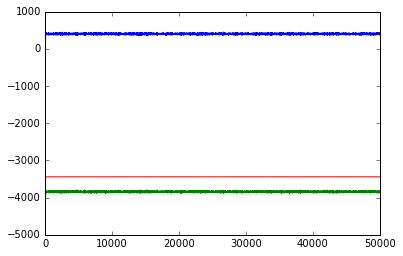

In [14]:
K = determine_kinetic_energy()
U = determine_potential_energy()
H = K + U

print("Initial K: " + str(K[0]))
print("Initial U: " + str(U[0]))
print("")
print("Average K: " + str(np.mean(K[-int(len(K)/2):])))
print("Average U: " + str(np.mean(U[-int(len(K)/2):])))
print("Average H: " + str(np.mean(H[-int(len(K)/2):])))

plt.plot(K)
plt.plot(U)
plt.plot(H)

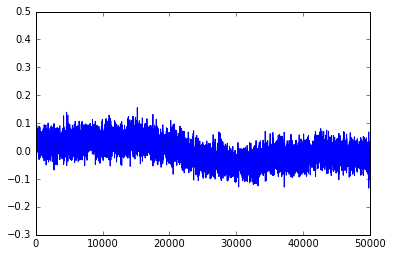

In [15]:
plt.plot(H - np.mean(H))